# Calculating Dynamics-weighted Principal Component time series and Empirical—Dynamical functions

This notebook combines forcing anomaly data matrices calculated in `1_`...`.ipynb` with adjoint output resulting from the adjoint runs set up in `2_`...`.ipynb` to calculate DPCs and EDFs. It is assumed that the raw model adjoint output has been converted to netCDF format using the script `ADJ_to_netcdf.py`, and each different adjoint run (for the four latitudes 25N-55N) is located in a directory named, e.g., `/wherever/your/adjoint/output/is/MVT55/` (change accordingly)

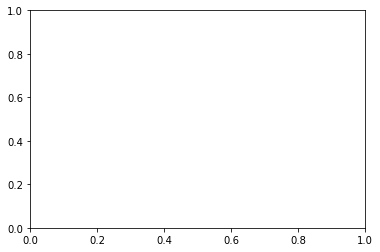

In [2]:
from DPC_functions import * 

# Load adjoint output

In [4]:
#  Open each adjoint file, reduce the spatial dimensionality to that of the data matrix (concatenating wind stress directions), reverse the lag-time order:
# hflux_ad=xr.open_dataset('/glade/work/dafydd/PLEIADES_OUTPUT/UOHC_SPG_1y/ADJqnet.nc',decode_times=False).ADJqnet.values.reshape(-1,13*90*90)[::-1,Ti]

# tauxy_ad=np.hstack([\
#         xr.open_dataset('/glade/work/dafydd/PLEIADES_OUTPUT/UOHC_SPG_1y/ADJtaux.nc',decode_times=False).ADJtaux.values.reshape(-1,13*90*90)[::-1,Ui],\
#         xr.open_dataset('/glade/work/dafydd/PLEIADES_OUTPUT/UOHC_SPG_1y/ADJtauy.nc',decode_times=False).ADJtauy.values.reshape(-1,13*90*90)[::-1,Vi]])

hflux_ad=xr.open_dataset('/wherever/your/adjoint/output/is/UOHC_SPG_1y/ADJqnet.nc',decode_times=False).ADJqnet.values.reshape(-1,13*90*90)[::-1,Ti]
tauxy_ad=np.hstack([\
        xr.open_dataset('/wherever/your/adjoint/output/is/UOHC_SPG_1y/ADJtaux.nc',decode_times=False).ADJtaux.values.reshape(-1,13*90*90)[::-1,Ui],\
        xr.open_dataset('/wherever/your/adjoint/output/is/UOHC_SPG_1y/ADJtauy.nc',decode_times=False).ADJtauy.values.reshape(-1,13*90*90)[::-1,Vi]])


# Load forcing data matrices

In [5]:
# As calculated in 1_:

hflux_X = np.load('/glade/work/dafydd/patterns_and_decompositions/hflux_X.npy') 
tauxy_X = np.load('/glade/work/dafydd/patterns_and_decompositions/uvstress_X.npy')

# hflux_X=np.load('hflux_anomaly_data_matrix.npy')
# tauxy_X=np.load('tauxy_anomaly_data_matrix.npy')

# Calculate leading DPCs and EDFs

In [6]:
%%time
################# Heat flux
DPC_hflux,_,_=la.svds(hflux_X.dot(hflux_ad.T),k=1)
EDF_hflux    = hflux_X.T.dot(DPC_hflux)

################## Wind stress
DPC_tauxy,_,_=la.svds(tauxy_X.dot(tauxy_ad.T),k=1)
EDF_tauxy    = tauxy_X.T.dot(DPC_tauxy)


CPU times: user 1min 18s, sys: 538 ms, total: 1min 19s
Wall time: 1min 20s


# Preview:

In [7]:
################# Hide some ugly warnings #################################################
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

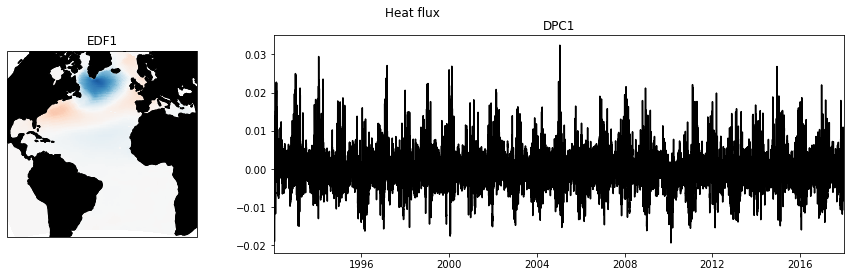

In [17]:
import matplotlib.gridspec as gridspec
import datetime as dt
t=np.arange(dt.datetime(1992,1,1,3,0,0),dt.datetime(2018,1,1,0,0,0),dt.timedelta(0.25))

fig = plt.figure()
gs = gridspec.GridSpec(nrows=1,ncols=2,width_ratios=[1,3])

ax=[]
[ax.append(fig.add_subplot(gs[i])) for i in range(2)]
#ax=np.array(ax).reshape(2,4).T

p,AX=unpack_and_map(EDF_hflux.flatten()/np.linalg.norm(EDF_hflux),ax=ax[0],vmin=-0.05,vmax=0.05,cmap='RdBu_r');ax[0]=AX

ax[1].plot(t,DPC_hflux,'k')
ax[1].set_xlim(t[0],t[-1])
ax[0].set_title('EDF1')
ax[1].set_title('DPC1')
fig.suptitle('Heat flux')
fig.set_size_inches(15,4)

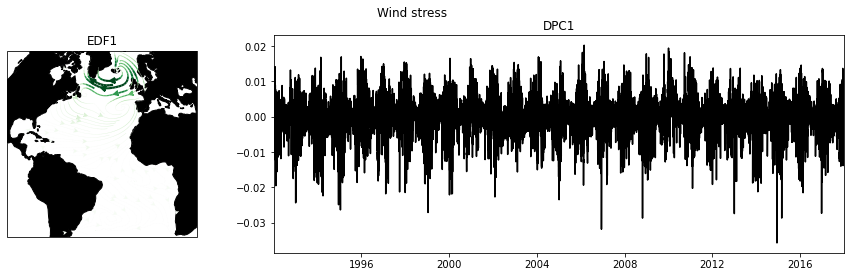

In [16]:
import matplotlib.gridspec as gridspec
import datetime as dt
t=np.arange(dt.datetime(1992,1,1,3,0,0),dt.datetime(2018,1,1,0,0,0),dt.timedelta(0.25))

fig = plt.figure()
gs = gridspec.GridSpec(nrows=1,ncols=2,width_ratios=[1,3])

ax=[]
[ax.append(fig.add_subplot(gs[i])) for i in range(2)]
# ax=np.array(ax).reshape(2,4).T

p,AX=atlstream(EDF_tauxy.flatten()/np.linalg.norm(EDF_tauxy),ax=ax[0],widthfactor=4,ss=1,density=4,arrowsize=1.,arrowstyle='fancy',vmin=0,vmax=0.025,cmap='Greens');ax[0]=AX

ax[1].plot(t,DPC_tauxy,'k')
ax[1].set_xlim(t[0],t[-1])
ax[0].set_title('EDF1')
ax[1].set_title('DPC1')
fig.suptitle('Wind stress')
fig.set_size_inches(15,4)
# fig.tight_layout()

# Save as npy files:

In [18]:
################# Heat flux
np.save('DPC_hflux.npy',DPC_hflux)
np.save('EDF_hflux.npy',EDF_hflux)

################## Wind stress
np.save('DPC_tauxy.npy',DPC_tauxy)
np.save('EDF_tauxy.npy',EDF_tauxy)
